<a href="https://colab.research.google.com/github/shivendr7/ml/blob/main/ResnetsCIFARpart1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function
import tensorflow.keras
from tensorflow.keras.layers import  Dense, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
import numpy as np
import os

(x_train, y_train), (x_test, y_test)= cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from six.moves import cPickle

R=10

x=x_train.astype('uint8')

fig, axes= plt.subplots(R, R, figsize=(10, 10))

for i in range(R):
  for j in range(R):
    k=np.random.choice(range(len(x)))
    axes[i][j].set_axis_off()
    axes[i][j].imshow(x[k])

((50000, 32, 32, 3),
 (1, 32, 32, 3),
 (32, 32, 3),
 (32, 32, 3),
 array([9], dtype=uint8))

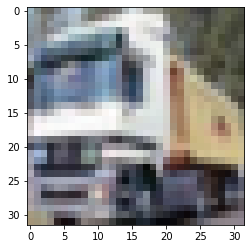

In [3]:
plt.imshow(x[1], cmap='gray', interpolation='nearest')
x.shape, x[:1].shape, x[1].shape, x[2:3][0].shape,y_train[1]

In [4]:
#learning rate decay schedule
def lr_schedule(epoch):
  lr=1e-3
  if epoch>180:
    lr*=0.5e-3
  elif epoch>160:
    lr*=1e-3
  elif epoch>120:
    lr*=1e-2
  elif epoch>80:
    lr*=1e-1
  print('changed learning rate:',lr)
  return lr

In [11]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
  """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
  conv=Conv2D(num_filters,
                kernel_size=kernel_size,
                strides=strides,
                padding='same',
                kernel_initializer='he_normal',
                kernel_regularizer=l2(1e-4))
  x=inputs
  if conv_first:
    x=conv(x)
    if batch_normalization:
      x=BatchNormalization()(x)
    if activation is not None:
      x=Activation(activation)(x)
  else:
    if batch_normalization:
      x=BatchNormalization()(x)
    if activation is not None:
      x=Activation(activation)(x)
    x=conv(x)
  
  return x


In [6]:
from tensorflow.keras.layers import Add

inputs=Input(shape= x_train.shape[1:])

outputs=resnet_layer(inputs=inputs)
#shorting=Add()([inputs,outputs])
modelResnetLayer=Model(inputs=inputs, outputs=outputs)
modelResnetLayer.compile()
modelResnetLayer.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 16)        448       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 16)        64        
_________________________________________________________________
activation (Activation)      (None, 32, 32, 16)        0         
Total params: 512
Trainable params: 480
Non-trainable params: 32
_________________________________________________________________


In [20]:
# (kernel_Width*kernel_height*layers_in_prev+1(bias))*layers_in_current
# batch normalization params= 4*no. of layers in current [in mode 1]
(5*5*3+1)*32

2432

In [12]:
from tensorflow.keras.layers import Add

inputs=Input(shape= x_train.shape[1:])
#done with padding valid
outputs=resnet_layer(inputs=inputs,num_filters=32,kernel_size=5)
#shorting=Add()([inputs,outputs])
modelResnetLayer=Model(inputs=inputs, outputs=outputs)
modelResnetLayer.compile()
modelResnetLayer.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 32)        2432      
_________________________________________________________________
batch_normalization_5 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
activation_5 (Activation)    (None, 28, 28, 32)        0         
Total params: 2,560
Trainable params: 2,496
Non-trainable params: 64
_________________________________________________________________


In [9]:
from tensorflow.keras.layers import MaxPooling2D
inputs=Input(shape= x_train.shape[1:])

outputs=resnet_layer(inputs=inputs)
#outputs=MaxPooling2D(pool_size=8)(outputs)
outputs=Flatten()(outputs)
modelResnetLayer=Model(inputs=inputs, outputs=outputs)
modelResnetLayer.compile()
modelResnetLayer.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 16)        448       
_________________________________________________________________
batch_normalization_3 (Batch (None, 32, 32, 16)        64        
_________________________________________________________________
activation_3 (Activation)    (None, 32, 32, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 16384)             0         
Total params: 512
Trainable params: 480
Non-trainable params: 32
_________________________________________________________________


ResNet V1

In [ ]:
def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature 
    map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of 
    filters is
    doubled. Within each stage, the layers have the same number 
    filters and the same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth-2)%6 !=0:
      raise ValueError('depth should be 6n+2')

    #model definition
    num_filters=16
    num_res_blocks=int((depth-2)/6)

    inputs=Input(shape= input_shape)
    x= resnet_layer(inputs= inputs)
    #Intantiate the stack of residual units

    for stack in range(3):
      for res_block in range(num_res_blocks):
        # first layer but not first stack
        strides=2 if stack>0 and res_block==0 else 1

        y=resnet_layer(inputs=x, num_filters=num_filters, strides=strides)
        y=resnet_layer(inputs=y, num_filters=num_filters, activation=None)

        # first layer but not first stack
        if stack>0 and res_block==0:
          # linear projection residual shortcut connection to match
          # changed dims

          x= resnet_layer(inputs=x, 
                          num_filters= num_filters,
                          kernel_size=1,
                          strides=strides,
                          activation=None,
                          batch_normalization=False)
          x= tensorflow.keras.layers.add([x,y])
          x= Activation('relu')(x)

        num_filters *=2
      
    x=AveragePooling2D(pool_size=8)(x)
    y=Flatten()(x)

    outputs= Dense(num_classes,
                     activation='softmax',
                     kernel_initializer='he_normal')(y)

    model= Model(inputs= inputs, outputs=outputs)
    return model


In [ ]:
x_train.shape[1:]

(32, 32, 3)

In [ ]:
x_train = x_train.astype('float32') /255
x_test = x_test.astype('float32') / 255

y_train_label=tensorflow.keras.utils.to_categorical(y_train, 10)
y_test_label=tensorflow.keras.utils.to_categorical(y_test, 10)

model=resnet_v1(input_shape=x_train.shape[1:], depth=(x_train.shape[3]*6 +2))

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()

changed learning rate: 0.001
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   448         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 16)   0           batch_normalization[0][0]        
_________________________________________________________________

In [ ]:
x_train.shape,y_train.shape

((50000, 32, 32, 3), (50000, 1))

In [17]:
import tensorflow as tf
x = tf.constant([[1., 2., 3.],
                 [4., 5., 6.]])
print(x.shape,x)
x = tf.reshape(x, [1, 2, 3, 1])  # give a shape accepted by tf.nn.max_pool
print(x.shape,x)
valid_pad = tf.nn.max_pool(x, [1, 2, 2, 1], [1, 2, 2, 1], padding='VALID')
same_pad = tf.nn.max_pool(x, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')

valid_pad.get_shape() == [1, 1, 1, 1],   same_pad.get_shape() == [1, 1, 2, 1]  # valid_pad is [5.] # same_pad is  [5., 6.]

(2, 3) tf.Tensor(
[[1. 2. 3.]
 [4. 5. 6.]], shape=(2, 3), dtype=float32)
(1, 2, 3, 1) tf.Tensor(
[[[[1.]
   [2.]
   [3.]]

  [[4.]
   [5.]
   [6.]]]], shape=(1, 2, 3, 1), dtype=float32)


(True, True)